## Homework - Clustering

1. Convert the k-means example from this notebook into a pipeline using `spark.ml.Pipeline` ([docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html), [example](https://spark.apache.org/docs/latest/ml-pipeline.html#pipeline)), `CrossValidator` ([docs](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation)) and `ParamGridBuilder` ([docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)) to do grid search over the `k` parameter. Note: you can use the `avgMetrics` property of the fitted model to find the Silhouette values for the tested `k` values.

Further reading on the Spark ML pipelines, and more examples: https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/

2. Experiment with other clustering algorithms from  https://spark.apache.org/docs/latest/ml-clustering.html (try at least 2 other).


In [1]:
#@title PySpark installation and imports
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
#@title Task-specific imports
from pyspark.sql.functions import explode, split, lower, col, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans

from sklearn import datasets
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#@title Initialize SparkSession, load and preprocess data
spark = SparkSession.builder \
    .appName("KMeansPipelineExample") \
    .getOrCreate()

iris_raw = datasets.load_iris()
iris_df = spark.createDataFrame(pd.DataFrame(iris_raw.data, columns=iris_raw.feature_names))

# VectorAssembler to assemble features
assembler = VectorAssembler(inputCols=iris_raw.feature_names, outputCol="features")
transformed = assembler.transform(iris_df)

In [4]:
#@title Solution - Exercise 1
#TODO: Put all this into a function
#Define the algorithm, evaluator, param grid builder, cross validator and build the pipeline
kmeans = KMeans() \
    .setSeed(1) \
    .setFeaturesCol("features") \
    .setPredictionCol("prediction")

evaluator = ClusteringEvaluator() \
    .setFeaturesCol("features") \
    .setPredictionCol("prediction") \
    .setMetricName("silhouette")

pipeline = Pipeline(stages=[kmeans])

paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, range(2, 20)) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit the model
cv_model_km = crossval.fit(transformed)

# Extract the best model
bestModel = cv_model_km.bestModel
bestK = bestModel.stages[0].getK()

print("Best K (K Means):", bestK)
predictions_km = bestModel.transform(transformed)
silhouette_score = evaluator.evaluate(predictions_km)
print("Silhouette Score (K Means):", silhouette_score)

Best K (K Means): 2
Silhouette Score (K Means): 0.8503512229251465


In [5]:
#@title Solution - Exercise 2
gaussian_mixture = GaussianMixture().setSeed(1).setFeaturesCol("features") \
                    .setPredictionCol("prediction")
bisecting_kmeans = BisectingKMeans().setSeed(1).setFeaturesCol("features") \
                    .setPredictionCol("prediction")

pipeline_gm = Pipeline(stages=[gaussian_mixture])
pipeline_bk = Pipeline(stages=[bisecting_kmeans])

param_grid_gm = ParamGridBuilder() \
    .addGrid(gaussian_mixture.k, range(2, 20)) \
    .build()
param_grid_bk = ParamGridBuilder() \
    .addGrid(bisecting_kmeans.k, range(2, 20)) \
    .build()

crossval_gm = CrossValidator(estimator=pipeline_gm,
                             estimatorParamMaps=param_grid_gm,
                             evaluator=evaluator,
                             numFolds=3)
crossval_bk = CrossValidator(estimator=pipeline_bk,
                             estimatorParamMaps=param_grid_bk,
                             evaluator=evaluator,
                             numFolds=3)

cv_model_gm = crossval_gm.fit(transformed)
cv_model_bk = crossval_bk.fit(transformed)

# Best models
best_model_gm = cv_model_gm.bestModel
best_model_bk = cv_model_bk.bestModel

best_k_gm = best_model_gm.stages[-1].getK()
best_k_bk = best_model_bk.stages[-1].getK()

print("Best K (Gaussian Mixture):", best_k_gm)
predictions_gm = bestModel.transform(transformed)
silhouette_score = evaluator.evaluate(predictions_gm)
print("Silhouette Score (Gaussian Mixture):", silhouette_score)

print("Best K (Bisecting KMeans):", best_k_bk)
predictions_bk = bestModel.transform(transformed)
silhouette_score = evaluator.evaluate(predictions_bk)
print("Silhouette Score (Bisecting KMeans):", silhouette_score)

# Show predictions
#predictions_gm.show()
#predictions_bk.show()

Best K (Gaussian Mixture): 2
Silhouette Score (Gaussian Mixture): 0.8503512229251465
Best K (Bisecting KMeans): 2
Silhouette Score (Bisecting KMeans): 0.8503512229251465


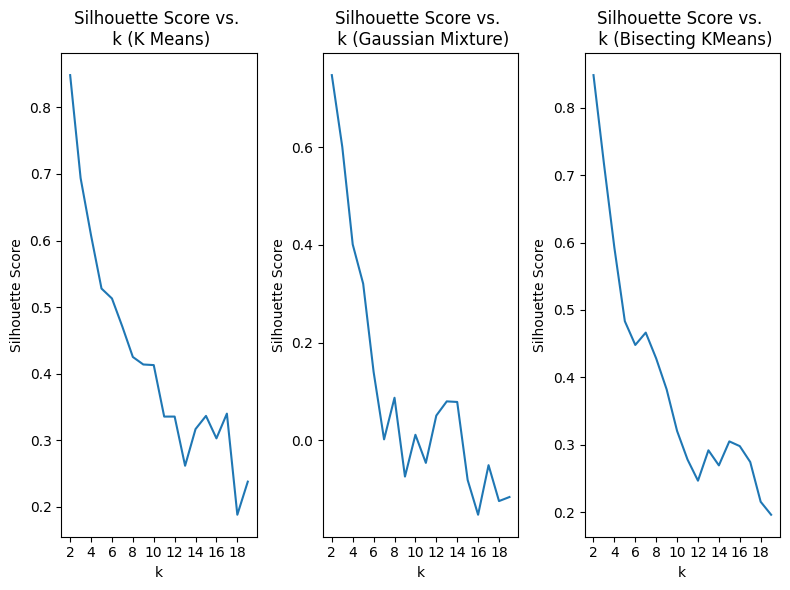

In [6]:
#@title Summary - Average silhouette scores for both models

avg_silhouette_scores_km = cv_model_km.avgMetrics
avg_silhouette_scores_gm = cv_model_gm.avgMetrics
avg_silhouette_scores_bk = cv_model_bk.avgMetrics

fig, ax = plt.subplots(1, 3, figsize =(8,6), )

ax[0].plot(range(2,20), avg_silhouette_scores_km)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Score vs. \n k (K Means)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(range(2,20), avg_silhouette_scores_gm)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score vs. \n k (Gaussian Mixture)')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[2].plot(range(2,20), avg_silhouette_scores_bk)
ax[2].set_xlabel('k')
ax[2].set_ylabel('Silhouette Score')
ax[2].set_title('Silhouette Score vs. \n k (Bisecting KMeans)')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

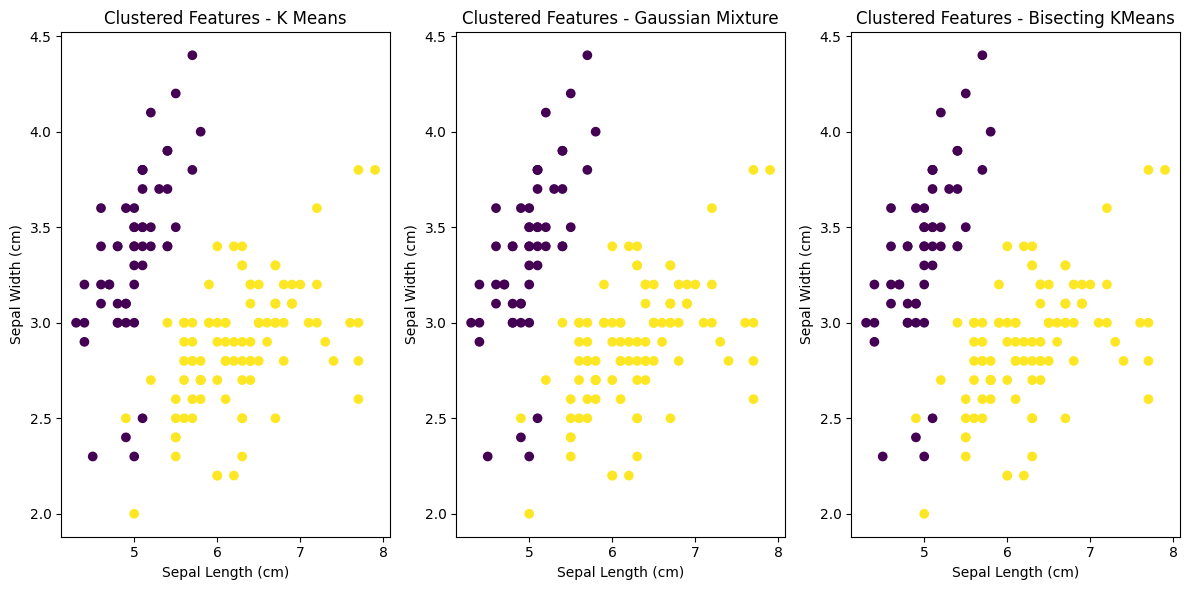

In [7]:
#@title Summary - Clustering visualisations
# Extract sepal length and sepal width from the original DataFrame
sepal_length = iris_df.select('sepal length (cm)').rdd.flatMap(lambda x: x).collect()
sepal_width = iris_df.select('sepal width (cm)').rdd.flatMap(lambda x: x).collect()

# Extract cluster predictions from the Gaussian Mixture and Bisecting KMeans models
predictions_km = predictions_km.select('prediction').rdd.flatMap(lambda x: x).collect()
predictions_gm = predictions_gm.select('prediction').rdd.flatMap(lambda x: x).collect()
predictions_bk = predictions_bk.select('prediction').rdd.flatMap(lambda x: x).collect()

# Plot the clustered features
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(sepal_length, sepal_width, c=predictions_km, cmap='viridis')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Clustered Features - K Means')

plt.subplot(1, 3, 2)
plt.scatter(sepal_length, sepal_width, c=predictions_gm, cmap='viridis')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Clustered Features - Gaussian Mixture')

plt.subplot(1, 3, 3)
plt.scatter(sepal_length, sepal_width, c=predictions_bk, cmap='viridis')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Clustered Features - Bisecting KMeans')

plt.tight_layout()
plt.show()

spark.stop()